_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Aleksejs Timcenko, Ali Gholamzadeh, Nitin Sharma

# Coding Lab 7 : Transcriptomics



In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2023-06-19 19:19:58+0330

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.14.0

sklearn: 1.2.2

pandas    : 2.0.2
numpy     : 1.24.3
matplotlib: 3.7.1

Watermark: 2.4.2



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [3]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [4]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

n_genes = len(genes)
n_cells = len(cells)

# Compute the average expression for each gene
gene_average_exp = np.mean(counts, axis=0)


# Compute the fraction of zeros for each gene
def count_fraction_zero(d):
    return (len(d) - np.count_nonzero(d)) / len(d)


gene_zero_frac = np.array(list(map(count_fraction_zero, counts.T)))

In [5]:
# Compute the Poisson prediction

# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
gene_zero_frac_expected = np.zeros_like(gene_average_exp)
for i, avg in enumerate(gene_average_exp):
    gene_zero_frac_expected[i] = np.exp(-avg)

In [6]:
gene_zero_frac_expected

array([0.91784928, 0.99945415, 0.99972704, ..., 0.4146063 , 0.92640843,
       0.99809082])

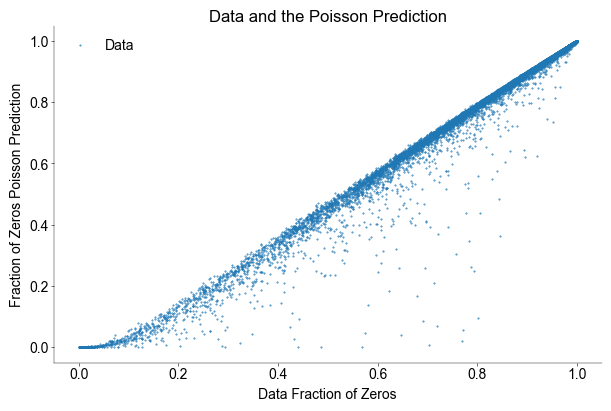

In [11]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))
# add plot

ax.scatter(gene_zero_frac, gene_zero_frac_expected, s=0.7, label="Data")
# ax.scatter(
#     gene_average_exp,
#     gene_zero_frac_expected,
#     s=0.7,
#     alpha=0.8,
#     c="red",
#     label="Poisson prediction",
# )

ax.set_title("Data and the Poisson Prediction")
ax.set_xlabel("Data Fraction of Zeros")
ax.set_ylabel("Fraction of Zeros Poisson Prediction")

plt.legend()
plt.show()

plt.show()

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [12]:
# Compute the variance of the expression counts of each gene
gene_var_exp = np.var(counts, axis=0)

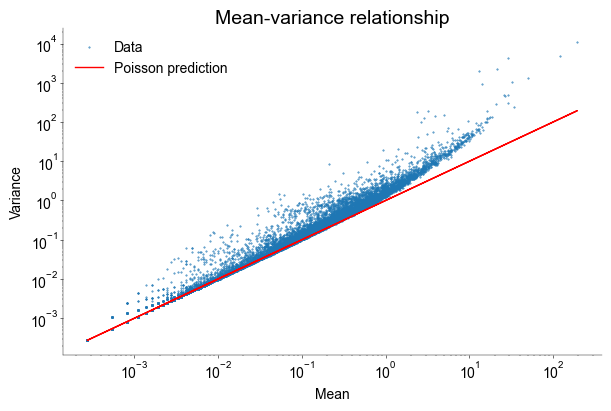

In [13]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))

# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------
ax.scatter(gene_average_exp, gene_var_exp, s=0.7, label="Data")
ax.plot(gene_average_exp, gene_average_exp, c="red", label="Poisson prediction")

ax.set_title("Mean-variance relationship", fontsize=14)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mean")
ax.set_ylabel("Variance")

plt.legend()
plt.show()

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [14]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.
fano = gene_var_exp / gene_average_exp

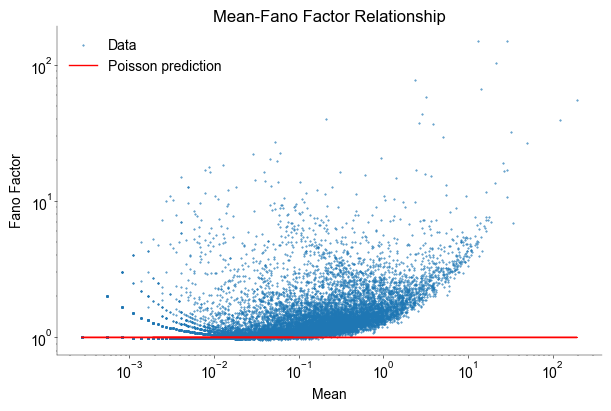

In [15]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
poisson_fano = np.ones_like(gene_average_exp)  # always one for poisson distribution

ax.scatter(gene_average_exp, fano, s=0.7, label="Data")
ax.plot(gene_average_exp, poisson_fano, c="red", label="Poisson prediction")

ax.set_title("Mean-Fano Factor Relationship")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mean")
ax.set_ylabel("Fano Factor")

plt.legend()
plt.show()

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

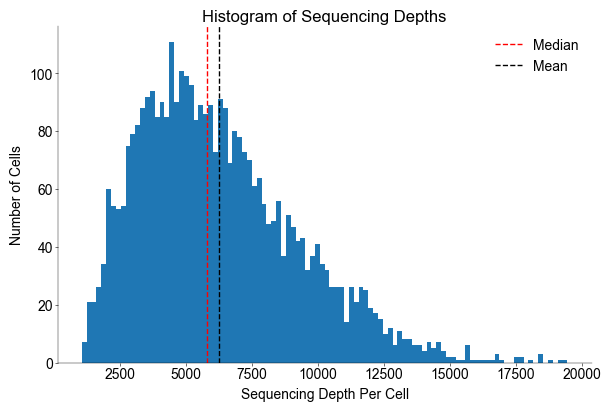

In [22]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell
cell_seq_depth = np.sum(counts, axis=1)


fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------
ax.hist(cell_seq_depth, bins=100)
ax.axvline(np.median(cell_seq_depth), ls="--", c="red", label="Median")
ax.axvline(np.mean(cell_seq_depth), ls="--", c="k", label="Mean")

ax.set_xlabel("Sequencing Depth Per Cell")
ax.set_ylabel("Number of Cells")
ax.set_title("Histogram of Sequencing Depths")
plt.legend()
plt.show()

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [23]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above
# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------
seq_depth_median = np.median(cell_seq_depth)
normalized_counts = counts / cell_seq_depth[:, None]
normalized_counts *= seq_depth_median

gene_var_exp_normalized = np.var(normalized_counts, axis=0)
gene_avg_exp_normalized = np.mean(normalized_counts, axis=0)

fano_normalized = gene_var_exp_normalized / gene_avg_exp_normalized

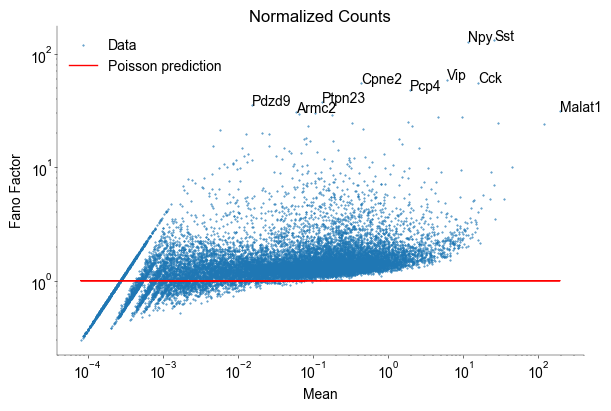

In [24]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

top_10_genes_indices = np.argsort(fano_normalized)[::-1][:10]
top_10_genes = genes[top_10_genes_indices]

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(gene_avg_exp_normalized, fano_normalized, s=0.7, label="Data")
ax.plot(gene_avg_exp_normalized, poisson_fano, c="red", label="Poisson prediction")
for i in top_10_genes_indices:
    ax.text(gene_avg_exp_normalized[i], fano_normalized[i], genes[i])
ax.set_title("Normalized Counts")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mean")
ax.set_ylabel("Fano Factor")

plt.legend()
plt.show()

In [27]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
print("top-10 genes with the highest normalized Fano factor:")
for i, gene in enumerate(top_10_genes):
    print(
        "gene: {}, normalized fano factor = {}".format(
            gene, fano_normalized[top_10_genes_indices[i]]
        )
    )

top-10 genes with the highest normalized Fano factor:
gene: Sst, normalized fano factor = 131.14152763839502
gene: Npy, normalized fano factor = 128.39902525416767
gene: Vip, normalized fano factor = 59.11491487972823
gene: Cck, normalized fano factor = 55.65105498639613
gene: Cpne2, normalized fano factor = 55.22031715653636
gene: Pcp4, normalized fano factor = 47.65007481295161
gene: Ptpn23, normalized fano factor = 37.246246826659586
gene: Pdzd9, normalized fano factor = 35.05542057702027
gene: Malat1, normalized fano factor = 31.42260972595051
gene: Armc2, normalized fano factor = 30.58952939206677


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [28]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------

# Transform the counts into normalized counts (as above)
# Select all genes with the normalized Fano factor above 3 and remove the rest
X = normalized_counts[:, fano_normalized > 3]
selected_genes = genes[fano_normalized > 3]

In [29]:
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

log_X = np.log2(X + 1)
sqrt_X = np.sqrt(X)

from sklearn.decomposition import PCA

# perform PCA
X_pca = PCA().fit_transform(X)
log_X_pca = PCA().fit_transform(log_X)
sqrt_X_pca = PCA().fit_transform(sqrt_X)

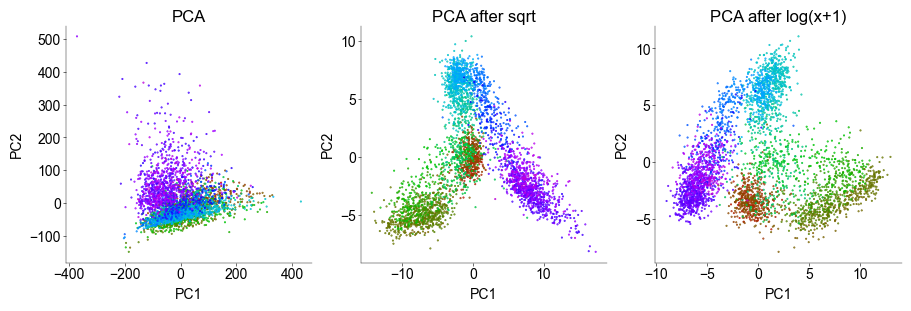

In [30]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------
point_colors = np.zeros((n_cells, 3))
for i in range(n_cells):
    point_colors[i] = clusterColors[clusters[i], :]
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], s=0.9, c=point_colors)
axs[0].set_title("PCA")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

axs[1].scatter(sqrt_X_pca[:, 0], sqrt_X_pca[:, 1], s=0.9, c=point_colors)

axs[1].set_title("PCA after sqrt")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")

axs[2].scatter(log_X_pca[:, 0], log_X_pca[:, 1], s=0.9, c=point_colors)

axs[2].set_title("PCA after log(x+1)")
axs[2].set_xlabel("PC1")
axs[2].set_ylabel("PC2")


plt.show()

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [31]:
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------

# Apply t-SNE to the 50 PCs

# Use default settings of openTSNE
# You can also use sklearn if you want

X_TSNE = TSNE().fit(X_pca[:, :50])
log_X_TSNE = TSNE().fit(log_X_pca[:, :50])
sqrt_X_TSNE = TSNE().fit(sqrt_X_pca[:, :50])

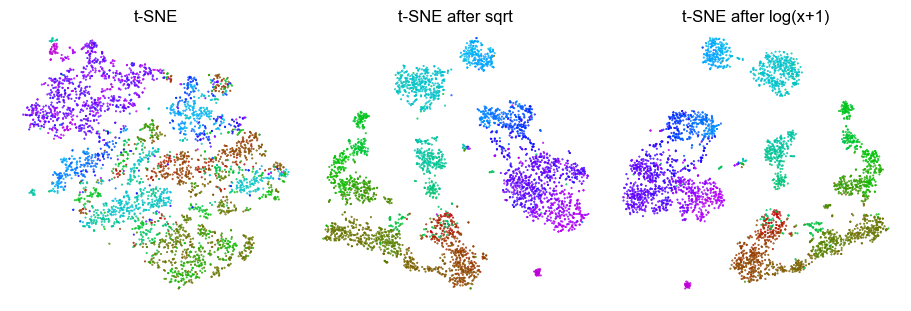

In [57]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

axs[0].scatter(X_TSNE[:, 0], X_TSNE[:, 1], s=0.9, c=point_colors)
axs[0].set_title("t-SNE")
axs[0].axis("off")


axs[1].scatter(sqrt_X_TSNE[:, 0], sqrt_X_TSNE[:, 1], s=0.9, c=point_colors)
axs[1].axis("off")

axs[1].set_title("t-SNE after sqrt")

axs[2].scatter(log_X_TSNE[:, 0], log_X_TSNE[:, 1], s=0.9, c=point_colors)
axs[2].axis("off")

axs[2].set_title("t-SNE after log(x+1)")


plt.show()

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [33]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [97]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

seed = 1
np.random.seed(seed)
# Construct kNN graph with k=15
A = kneighbors_graph(sqrt_X, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()
G = ig.Graph(zip(sources, targets))

In [ ]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type
partition = la.find_partition(G, la.RBConfigurationVertexPartition, seed=seed)
layout = ig.Graph.layout_drl(G)
ig.plot(partition, vertex_size=3, edge_width=0, layout=layout, alpha=0.3)

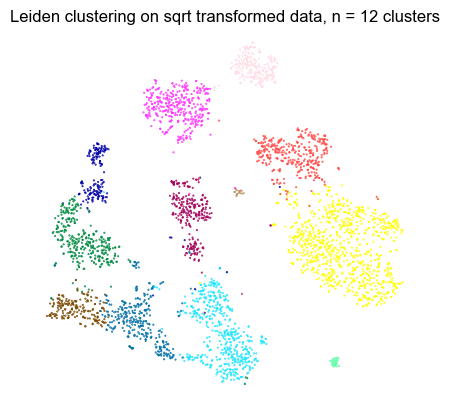

In [99]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------
pycairofig, ax = plt.subplots(figsize=(4, 4))
point_colors = clusterCols[partition._membership]
n_clusters = len(np.unique(partition._membership))

ax.scatter(sqrt_X_TSNE[:, 0], sqrt_X_TSNE[:, 1], s=0.9, c=point_colors)

ax.axis("off")
ax.set_title(
    "Leiden clustering on sqrt transformed data, n = {} clusters".format(n_clusters)
)
plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [108]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

partition = la.find_partition(
    G, la.RBConfigurationVertexPartition, resolution_parameter=1, seed=seed
)
print("n_clusters: {}".format(len(np.unique(partition._membership))))

partition_fewer = la.find_partition(
    G, la.RBConfigurationVertexPartition, resolution_parameter=0.2, seed=seed
)
print("n_clusters: {}".format(len(np.unique(partition_fewer._membership))))

partition_more = la.find_partition(
    G, la.RBConfigurationVertexPartition, resolution_parameter=3.4, seed=seed
)
print("n_clusters: {}".format(len(np.unique(partition_more._membership))))

n_clusters: 12
n_clusters: 6
n_clusters: 24


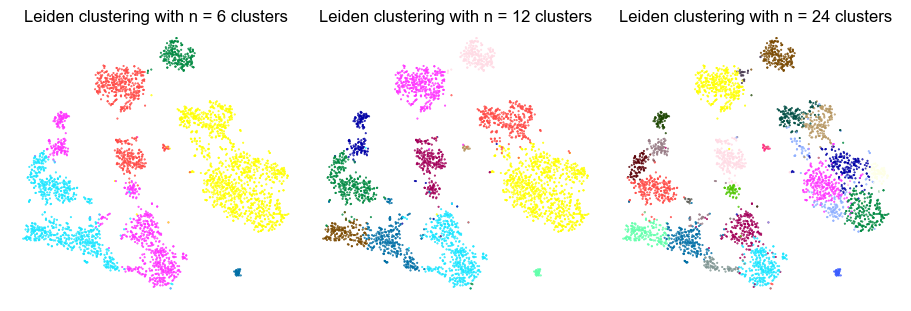

In [112]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

point_colors = clusterCols[partition_fewer._membership]
n_clusters = len(np.unique(partition_fewer._membership))

axs[0].scatter(sqrt_X_TSNE[:, 0], sqrt_X_TSNE[:, 1], s=0.9, c=point_colors)
axs[0].set_title("Leiden clustering with n = {} clusters".format(n_clusters))

axs[0].axis("off")


point_colors = clusterCols[partition._membership]
n_clusters = len(np.unique(partition._membership))

axs[1].scatter(sqrt_X_TSNE[:, 0], sqrt_X_TSNE[:, 1], s=0.9, c=point_colors)
axs[1].axis("off")

axs[1].set_title("Leiden clustering with n = {} clusters".format(n_clusters))

point_colors = clusterCols[partition_more._membership]
n_clusters = len(np.unique(partition_more._membership))

axs[2].scatter(sqrt_X_TSNE[:, 0], sqrt_X_TSNE[:, 1], s=0.9, c=point_colors)
axs[2].axis("off")

axs[2].set_title("Leiden clustering with n = {} clusters".format(n_clusters))


plt.show()